In [1]:
import keras
import fastai
from fastai.vision import *
from fastai.metrics import fbeta

import pandas as pd
import numpy as np

import os
import shutil
from pathlib import Path
import tarfile

import matplotlib.pyplot as plt
from PIL import Image

Using TensorFlow backend.


In [2]:
path_raw_data = Path('../../data/kaggle/sample/')
files = os.listdir(path_raw_data)
files

['images', 'sample.zip', 'sample_labels.csv']

In [3]:
path_data = path_raw_data/'images'

In [4]:
verify_images(path_data, n_channels=1)

In [5]:
img_files = os.listdir(path_data)
img_files[:5], len(img_files)

(['00025360_008.png',
  '00012116_001.png',
  '00016291_006.png',
  '00022893_000.png',
  '00017136_018.png'],
 5607)

In [6]:
df_labels = pd.read_csv(path_raw_data/"sample_labels.csv")
# print(df_labels.head(), df_labels.shape)
df_labels = df_labels.loc[df_labels['Image Index'].isin(img_files)]
# df_labels = df_labels.iloc[:200]
df_labels.shape

(5606, 11)

In [7]:
df_labels.loc[df_labels['Finding Labels'] == 'No Finding', 'Finding Labels'] = ''
df_labels = df_labels.groupby('Finding Labels').apply(lambda x: x.sample(1)).reset_index(drop=True)
df_labels

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00020450_006.png,,6,20450,059Y,M,AP,3004,2544,0.139000,0.139000
1,00013198_000.png,Atelectasis,0,13198,064Y,M,PA,2992,2991,0.143000,0.143000
2,00029940_007.png,Atelectasis|Cardiomegaly,7,29940,060Y,M,AP,3056,2544,0.139000,0.139000
3,00020349_011.png,Atelectasis|Cardiomegaly|Consolidation,11,20349,018Y,F,PA,2406,2593,0.143000,0.143000
4,00020213_045.png,Atelectasis|Cardiomegaly|Consolidation|Effusio...,45,20213,072Y,F,AP,3056,2544,0.139000,0.139000
5,00023325_019.png,Atelectasis|Cardiomegaly|Effusion,19,23325,081Y,F,AP,2048,2500,0.168000,0.168000
6,00004402_008.png,Atelectasis|Cardiomegaly|Effusion|Fibrosis|Inf...,8,4402,070Y,M,AP,3056,2544,0.139000,0.139000
7,00005741_002.png,Atelectasis|Cardiomegaly|Effusion|Fibrosis|Nodule,2,5741,064Y,M,PA,2992,2991,0.143000,0.143000
8,00022290_000.png,Atelectasis|Cardiomegaly|Effusion|Infiltration...,0,22290,058Y,M,PA,2544,2910,0.139000,0.139000
9,00017999_001.png,Atelectasis|Cardiomegaly|Effusion|Mass,1,17999,032Y,F,AP,2500,2048,0.168000,0.168000


In [9]:
tfms = get_transforms(do_flip=False, flip_vert=False, max_rotate=0.02)

basic_block = (ImageList
                .from_df(df_labels,
                         path=path_data)
                .random_split_by_pct(0.2)
                .label_from_df(label_delim='|'))

db_xrays = (basic_block
            .transform(tfms, 
                       size=64) 
            .databunch(bs=32))

db_xrays.normalize(imagenet_stats)

db_xrays.export()

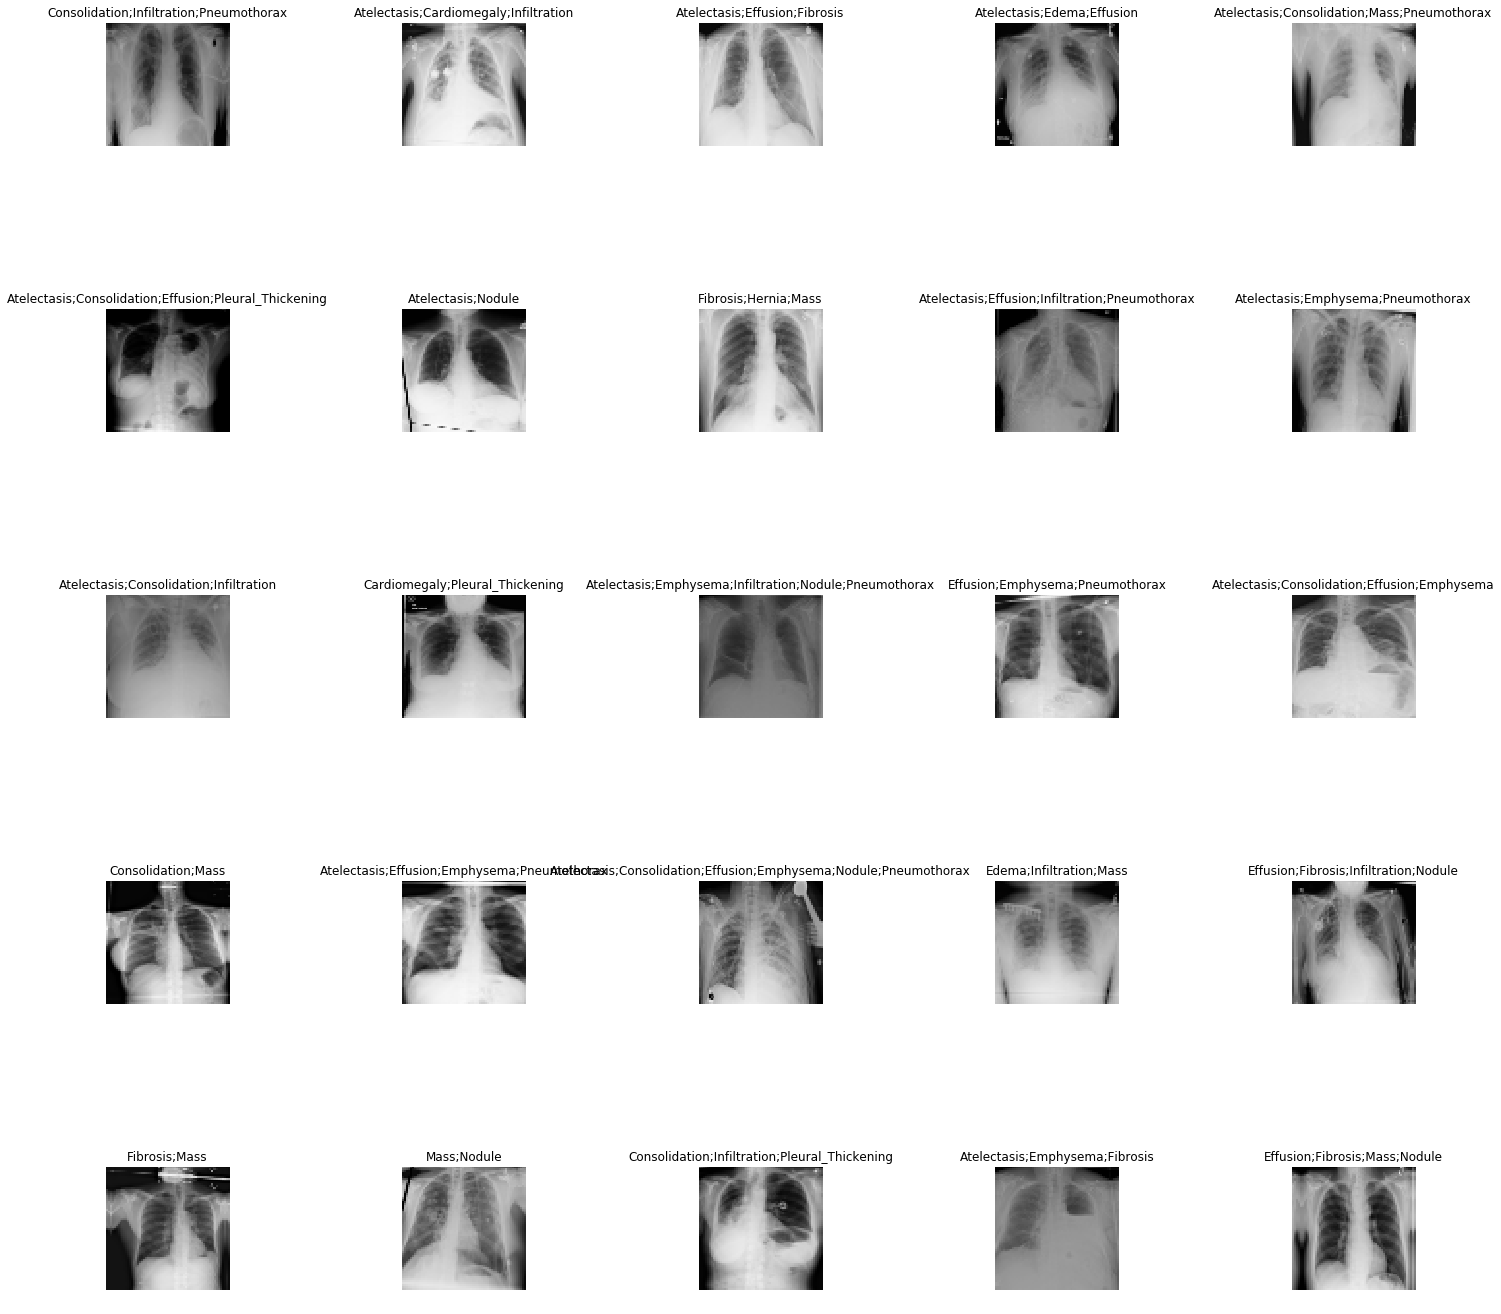

In [65]:
db_xrays.show_batch()

In [49]:
# def accuracy(input:Tensor, targs:Tensor)->Rank0Tensor:
#     "Compute accuracy with `targs` when `input` is bs * n_classes."
#     n = targs.shape[0]
#     input = input.argmax(dim=-1).view(n,-1)
#     targs = targs.view(-1).long()
#     return (input==targs).float().mean()

model = create_cnn(data=db_xrays, 
                   arch=models.vgg16_bn, 
                   metrics=[fbeta])

In [77]:
model.data.c, model.data.classes

(14,
 ['Atelectasis',
  'Cardiomegaly',
  'Consolidation',
  'Edema',
  'Effusion',
  'Emphysema',
  'Fibrosis',
  'Hernia',
  'Infiltration',
  'Mass',
  'Nodule',
  'Pleural_Thickening',
  'Pneumonia',
  'Pneumothorax'])

In [110]:
model.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.31E-02


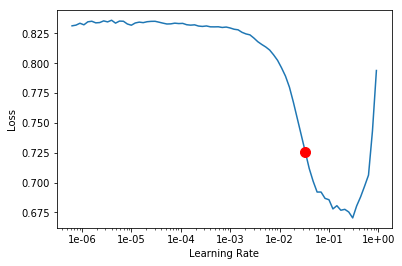

In [111]:
model.recorder.plot()

In [73]:
# x,y = next(iter(db_xrays.valid_dl))
# y
# # list(zip(db_xrays.classes, y[0]))

In [78]:
model.fit_one_cycle(cyc_len=1, max_lr=3.3e-2)

epoch,train_loss,valid_loss,fbeta,time
1,0.704101,0.641324,0.334713,00:09


In [134]:
model.save('stage1')

In [143]:
model.load('stage1')
model.unfreeze()
# model.freeze_to(100)
# model.freeze()

In [140]:
model.data = (basic_block
            .transform(tfms, 
                       size=100) 
            .databunch(bs=20))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06


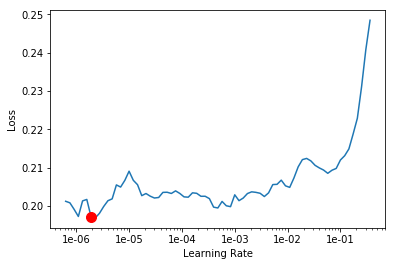

In [141]:
model.lr_find()
model.recorder.plot()

In [144]:
model.fit_one_cycle(cyc_len=5, max_lr=slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,fbeta
1,0.201796,0.202957,0.583518
2,0.203708,0.208164,0.587136
3,0.199574,0.195937,0.589914
4,0.192358,0.195101,0.593595
5,0.191924,0.195174,0.595510


In [146]:
model.save('stage2')

In [87]:
dt = vision.open_image(path_data/'00024807_000.png')
predict_class,predict_idx,predict_values = model.predict(dt)
predict_values

tensor([0.3305, 0.0319, 0.0299, 0.0054, 0.1823, 0.1157, 0.0067, 0.0083, 0.6314,
        0.2818, 0.4877, 0.1619, 0.0310, 0.2029])